In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
import gmaps

import sys
sys.path.append("../")
from location import *

# Keep data consistent, load from disk.
LOAD_DATA_FROM_DISK = True

RAW_FOLDER = 'raw_data/'
PROCESSED_FOLDER = 'processed_data/'

In [3]:
df = pd.read_json(PROCESSED_FOLDER + 'feb20.json')

In [4]:
len(df)

154799

In [173]:
%%time
stops, places, moves = get_stops_places_and_moves_daily(df, merge=False, move_duration=3, place_dist=50)

CPU times: user 2min 17s, sys: 562 ms, total: 2min 17s
Wall time: 2min 16s


In [ ]:
dates = sorted(stops.date.unique())
dates = np.array(dates)
dates

# Map Plotting

In [170]:
import gmplot

# Create map orientation centre
lat_mean = stops.latitude.mean()
lon_mean = stops.longitude.mean()

# Create a Gmap Plot object
gmap = gmplot.GoogleMapPlotter(lat_mean, lon_mean, 17)

In [171]:
# Draw places and stops
for place_id in places.place.values:
    # Single place example
    place_radius = 15 # Not the same as meters!
    place_lat = places[places.place == place_id].latitude.values
    place_lon = places[places.place == place_id].longitude.values

    # Plot place with a radius
    gmap.scatter(place_lat, place_lon, color='red', size=place_radius, marker=False)

    # Create a convex hull of the stops
    lats = stops[stops.place == place_id].latitude.values
    lons = stops[stops.place == place_id].longitude.values
    
    # Plot stops as markers
    for lat, lon in zip(lats, lons):
        gmap.marker(lat, lon, color='cornflowerblue')

In [172]:
# Draw map object
gmap.draw('MUC_map.html')

# Calculating the Routine Index

In [ ]:
HOURS_IN_A_DAY = 24

def print_hour_matrix(M):
    for i, row in enumerate(M):
        line = "[{:0>2} - {:0>2}] ".format(i, i+1)
        for e in row:
            line += '%0.2f ' % e
        print(line)

def make_hour_matrix(stops, num_places):
    h = np.zeros((HOURS_IN_A_DAY, num_places))
    
    for index, row in stops.iterrows():
        pid = row.place
        start_hour = row.arrival.hour
        end_hour   = row.departure.hour
        
        # If user arrived and departed within the same hour
        # Then the time stayed is the diff between departure and arrival
        if start_hour == end_hour:
            h[start_hour, pid] = row.departure.minute - row.arrival.minute
        
        else:
            # Arrival hour
            h[start_hour, pid] = 60 - row.arrival.minute

            # In between
            for hour in range(start_hour+1, end_hour):
                h[hour, pid] = 60

            # Departure hour
            h[end_hour, pid] = row.departure.minute
        
    return h / 60 # Normalize by 60 mins

In [3]:
# Plot a matrix as a color map
def matrix_plot(m):
    plt.figure(figsize=(10,10))
    plt.imshow(m, cmap='bone')
    plt.title('Hour matrix')
    plt.xlabel('Place ID')
    plt.ylabel('Timeslot')
    plt.yticks(range(HOURS_IN_A_DAY), ["[{:0>2} - {:0>2}] ".format(i, i+1) for i in range(HOURS_IN_A_DAY)])
    plt.xticks(range(m.shape[1]))
    plt.show()

In [4]:
s1 = stops[stops.date == dates[-3]]
s1

NameError: name 'stops' is not defined

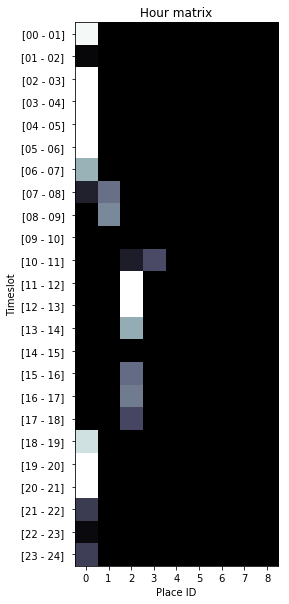

In [27]:
h1 = make_hour_matrix(s1, len(places))
matrix_plot(h1)

In [42]:
def RI(h_mean, h, end_hour=24):
    '''
    input:
        h_mean (2d matrix): Historical Mean Matrix
        h (2d matrix): Hour Matrix for a day
    
    output:
        routine_index: -1 (could not be calculated) or [0 to 1]. 
    '''
    if h_mean.sum() == 0:
        return -1.0 # no routine index could be calculated
    
    assert(h_mean.shape == h.shape)
    
    m,n = h.shape
    
    overlap = 0.0
    for i in range(m):
        for j in range(n):
            overlap += min(h_mean[i,j], h[i,j])
            
    max_overlap = min(h_mean.sum(), h.sum())
    
    return overlap / max_overlap

## Using todays stops and historical stops to calculate routine index
I.e. no updating of routine matrix, always recalculate it.

In [56]:
df = df.sort_index()

In [60]:
STOPS = {}
PLACES = {}
MOVES = {}

for date in dates:
    print('Date:', date)
    # Select data by date
    data = df[df.date == date]
    
    # Find stops, moves, places
    S, P, M = get_stops_places_and_moves_daily(data, merge=False, move_duration=3)
    
    # Store them
    STOPS[date] = S
    PLACES[date] = P
    MOVES[date] = M

Date: 2020-02-12T00:00:00.000000000
Date: 2020-02-13T00:00:00.000000000
Date: 2020-02-14T00:00:00.000000000
Date: 2020-02-15T00:00:00.000000000
Date: 2020-02-16T00:00:00.000000000
Date: 2020-02-17T00:00:00.000000000
Date: 2020-02-18T00:00:00.000000000
Date: 2020-02-19T00:00:00.000000000
Date: 2020-02-20T00:00:00.000000000


In [62]:
def plot_today_and_routine(today, routine, routine_after, save=False):
    interval_strings = ["[{:0>2} - {:0>2}] ".format(i, i+1) for i in range(HOURS_IN_A_DAY)]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_size_inches((10,10))

    ax1.imshow(routine, cmap='bone')
    ax1.set_title('Routine')
    ax1.set_xlabel('Place ID')
    ax1.set_ylabel('Timeslot')
    ax1.set_yticks(range(HOURS_IN_A_DAY))
    ax1.set_yticklabels(interval_strings)
    ax1.set_xticks(range(routine.shape[1]))
    
    ax2.imshow(today, cmap='bone')
    ax2.set_title('Today')
    ax2.set_xlabel('Place ID')
    ax2.set_ylabel('Timeslot')
    ax2.set_yticks(range(HOURS_IN_A_DAY))
    ax2.set_yticklabels(interval_strings)
    ax2.set_xticks(range(today.shape[1]))
    
    ax3.imshow(routine_after, cmap='bone')
    ax3.set_title('Updated Routine')
    ax3.set_xlabel('Place ID')
    ax3.set_ylabel('Timeslot')
    ax3.set_yticks(range(HOURS_IN_A_DAY))
    ax3.set_yticklabels(interval_strings)
    ax3.set_xticks(range(routine_after.shape[1]))
    
    if save:
        plt.savefig('routine.png')
    plt.show()

In [93]:
DISTF = lambda a, b: geodesic(a, b).meters

def get_places_2(stops, dist=25, distf=DISTF):
    """
    Compute places for one user with DBSCAN algorithm.

    Compute places as clusters of stops and assign place labels to stops.

    :param stops: dataframe of stops with columns: [lat, lon].
    :param dist: maximum distance between stops in a cluster measured in meters.
    :param distf: distance function of the form: ((lat, lon),(lat, lon)) --> (meters)
    :return: dataframe of labeled stops and dataframe of places.
    """
    if stops.empty:
        stops['place'] = []
        places = pd.DataFrame(columns=['user_id', 'place', 'latitude', 'longitude', 'duration', 'stops'])
    else:
        points = stops[['latitude', 'longitude']].values
        dbs = DBSCAN(dist, min_samples=1, metric=distf).fit(points)
        stops['place'] = dbs.labels_
        places = stops.groupby('place').agg({
            'latitude': np.median,
            'longitude': np.median,
            'duration': np.sum,
            'samples': len,
        }).reset_index()
        places.rename(columns={'samples': 'stops'}, inplace=True)
        places.insert(0, 'user_id', stops.user_id.values[0])
    return stops, places

array(['2020-02-12T00:00:00.000000000', '2020-02-13T00:00:00.000000000',
       '2020-02-14T00:00:00.000000000', '2020-02-15T00:00:00.000000000',
       '2020-02-16T00:00:00.000000000', '2020-02-17T00:00:00.000000000',
       '2020-02-18T00:00:00.000000000', '2020-02-19T00:00:00.000000000'],
      dtype='datetime64[ns]')

Routine index: -1.00
-----------------------------------


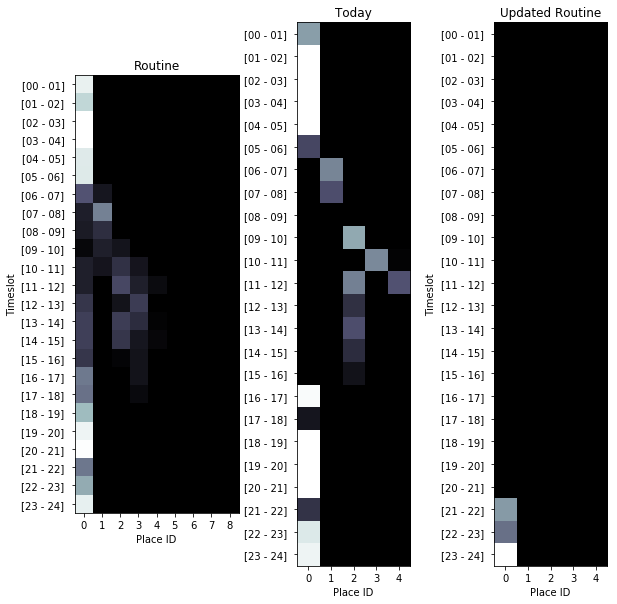

Routine index: 0.82
-----------------------------------


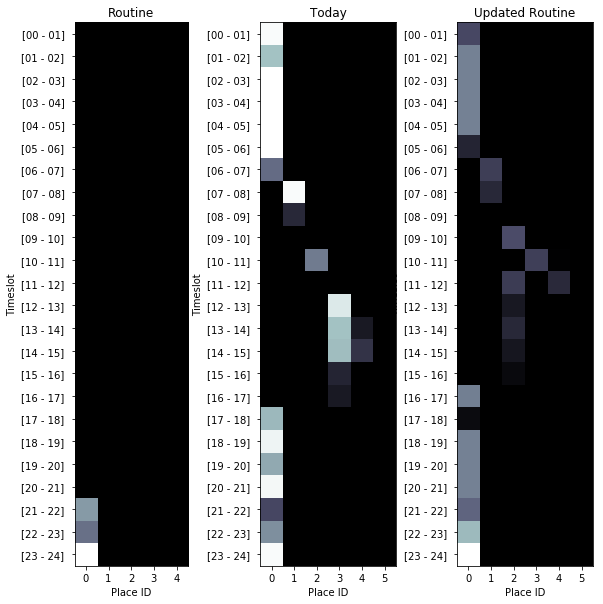

Routine index: 0.71
-----------------------------------


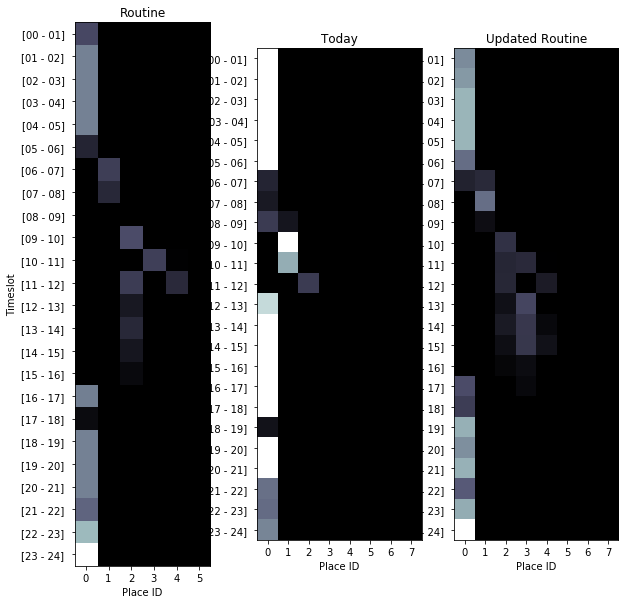

Routine index: 0.65
-----------------------------------


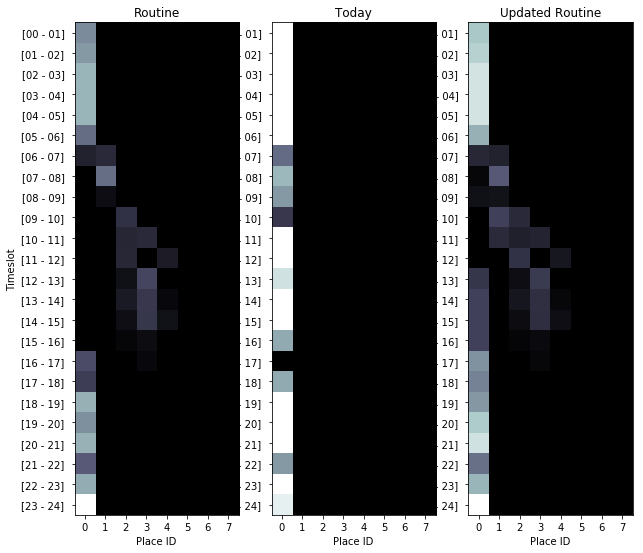

Routine index: 0.75
-----------------------------------


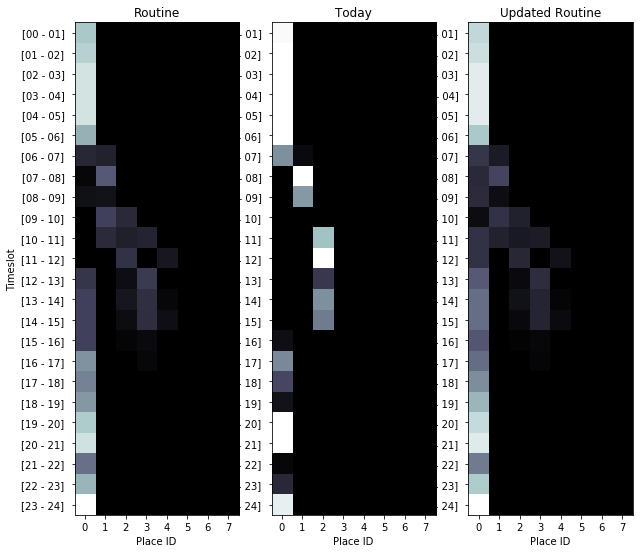

Routine index: 0.64
-----------------------------------


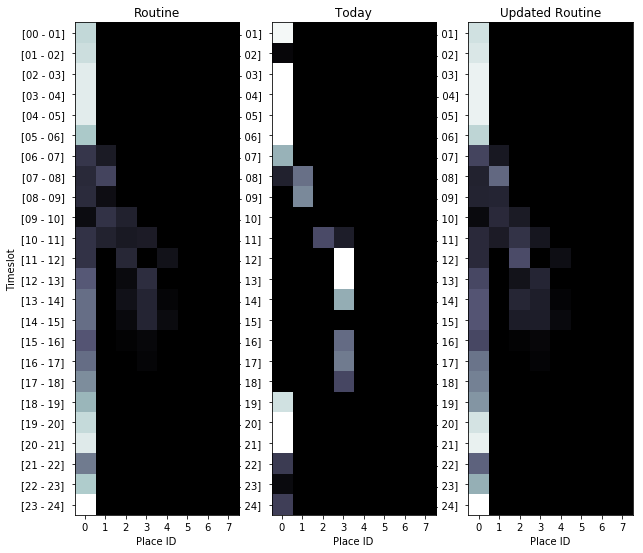

Routine index: 0.58
-----------------------------------


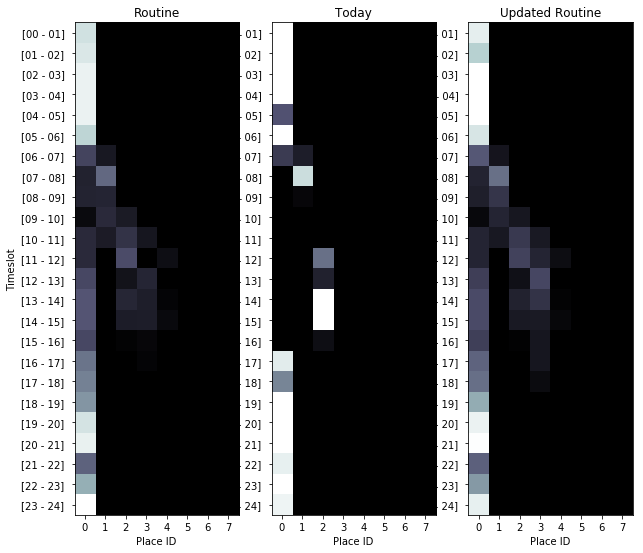

Routine index: 0.72
-----------------------------------


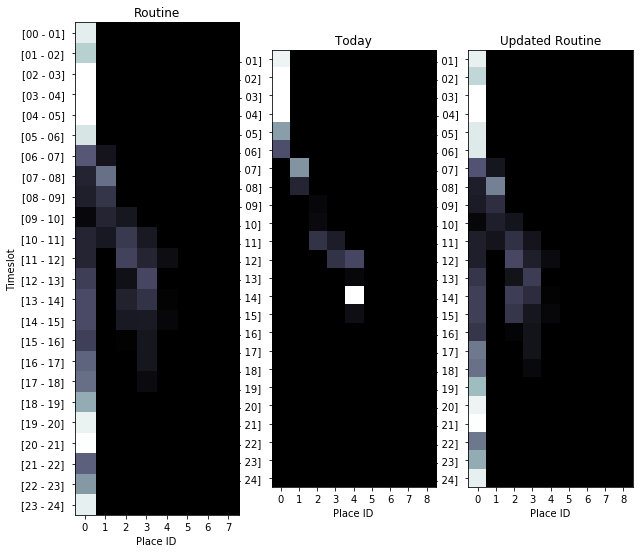

Routine index: 0.65
-----------------------------------


In [118]:
for date in dates:
    # Calculate todays matrix
    stops_today = STOPS[date]
    stops_so_far = [STOPS[d] for d in dates[dates <= date]]
    stops_so_far = pd.concat(stops_so_far)
    stops_so_far = stops_so_far.sort_values(['arrival'])
    stops_so_far = stops_so_far.reset_index()
    stops_so_far, places_so_far = get_places_2(stops_so_far)
    
    number_of_places = len(places_so_far)
    
    hour_matrix_today = make_hour_matrix(stops_today, number_of_places)
    dates_hist = dates[dates < date]
    
    if len(dates_hist) > 0:
        hour_matrices_hist = [make_hour_matrix(STOPS[date_hist], number_of_places) for date_hist in dates_hist]
        new_routine_matrix = np.mean(hour_matrices_hist, axis=0)
        ri = RI(new_routine_matrix, hour_matrix_today)
        plot_today_and_routine(hour_matrix_today, routine_matrix, new_routine_matrix)
        routine_matrix = new_routine_matrix
        
    else:
        ri = -1
    print('Routine index: %0.2f' % ri)
    
    
    print('-'*35)

In [119]:
plot_today_and_routine(hour_matrix_today, routine_matrix, save=True)

TypeError: plot_today_and_routine() missing 1 required positional argument: 'routine_after'

### Calculate routine index based on time of day of last stop

In [202]:
stops_last_date = stops[stops.date == dates[-1]]
stops_last_date

,user_id,date,latitude,longitude,samples,arrival,departure,duration,place
66,0,2020-02-20,48.171261,11.563222,4126,2020-02-20 00:03:46.561,2020-02-20 05:21:08.144,317.359717,0
67,0,2020-02-20,48.141207,11.568586,314,2020-02-20 06:25:07.516,2020-02-20 07:10:46.037,45.642017,1
68,0,2020-02-20,48.262452,11.667441,810,2020-02-20 08:58:52.001,2020-02-20 10:14:08.609,75.276800,8
69,0,2020-02-20,48.268040,11.671871,233,2020-02-20 10:52:10.656,2020-02-20 11:14:40.626,22.499500,3
70,0,2020-02-20,48.262854,11.666533,613,2020-02-20 11:41:48.544,2020-02-20 12:42:39.352,60.846800,2
71,0,2020-02-20,48.262858,11.666535,685,2020-02-20 12:58:01.091,2020-02-20 14:04:17.843,66.279200,2


In [211]:
last_hour = stops_last_date.departure.dt.hour.iloc[-1]
last_hour

14

In [219]:
hour_matrix_last_date = make_hour_matrix(stops_last_date, number_of_places)

In [220]:
RI(routine_matrix[:last_hour], hour_matrix_last_date[:last_hour])

0.9471230158730158

In [221]:
RI(routine_matrix, hour_matrix_last_date)

0.9383005401234568

## Binary approach

In [276]:
def make_binary_matrix(stops, num_places):
    h = np.zeros((HOURS_IN_A_DAY, num_places))
    
    for index, row in stops.iterrows():

        # In between
        for hour in range(row.arrival.hour, row.departure.hour + 1):
            h[hour, row.place] = 1.0
        
    return h

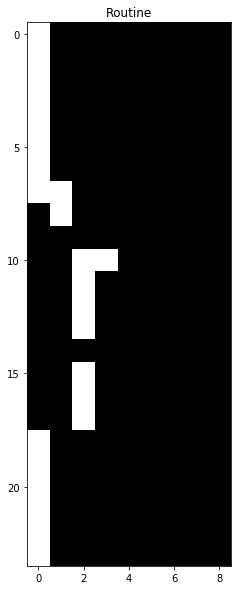

In [277]:
h1 = make_binary_matrix(s1, len(places))
matrix_plot(h1)

Routine index: -1.00
-----------------------------------


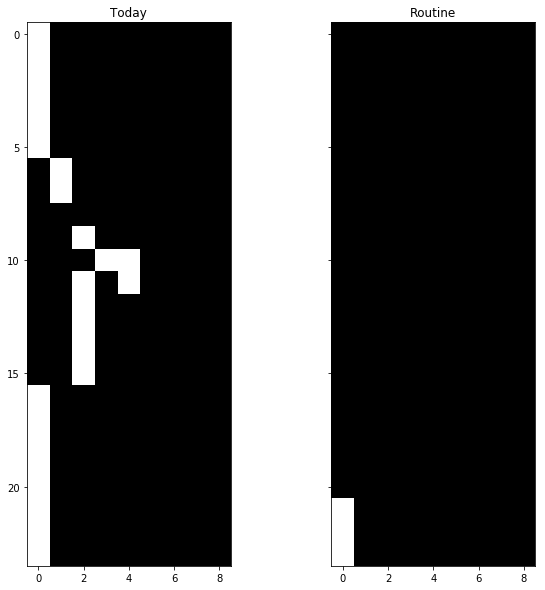

Routine index: 0.90
-----------------------------------


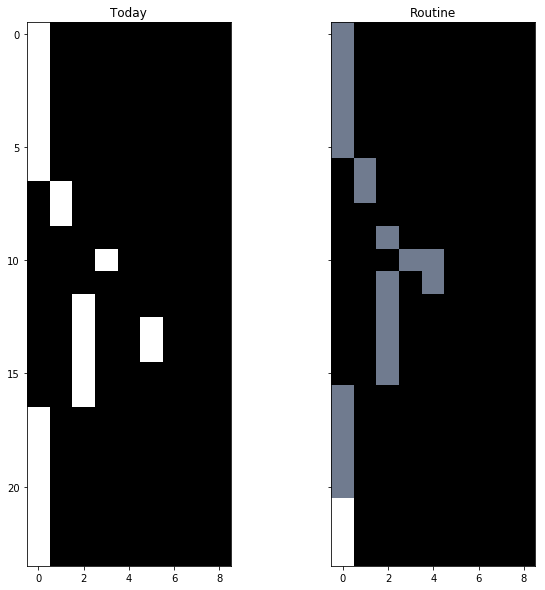

Routine index: 0.93
-----------------------------------


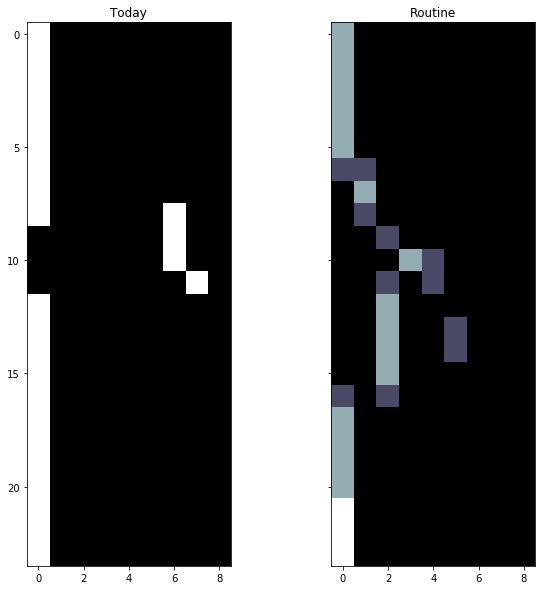

Routine index: 0.90
-----------------------------------


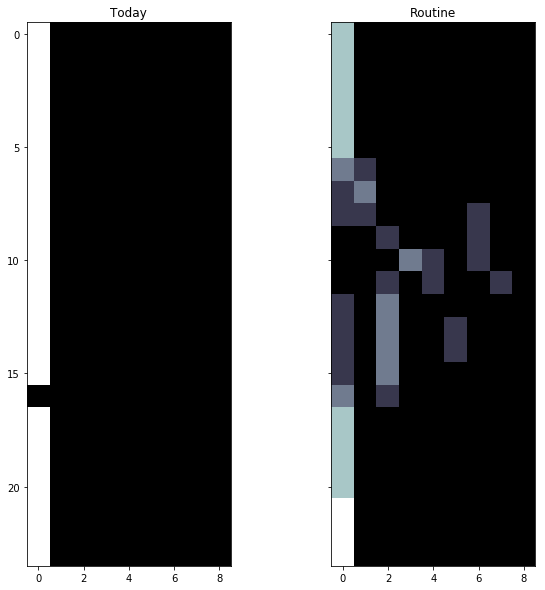

Routine index: 0.92
-----------------------------------


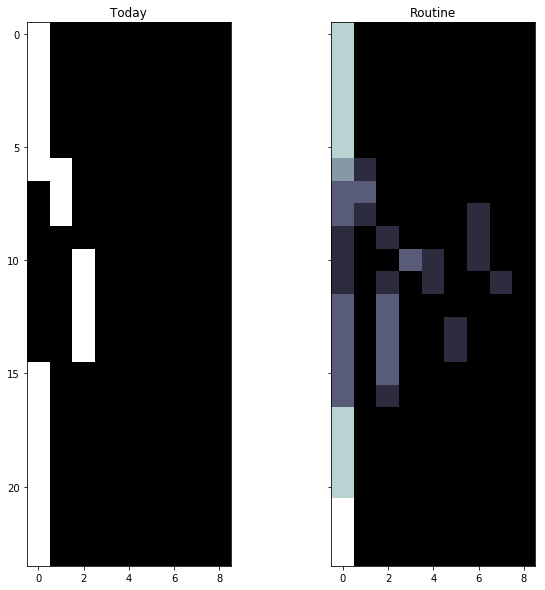

Routine index: 0.93
-----------------------------------


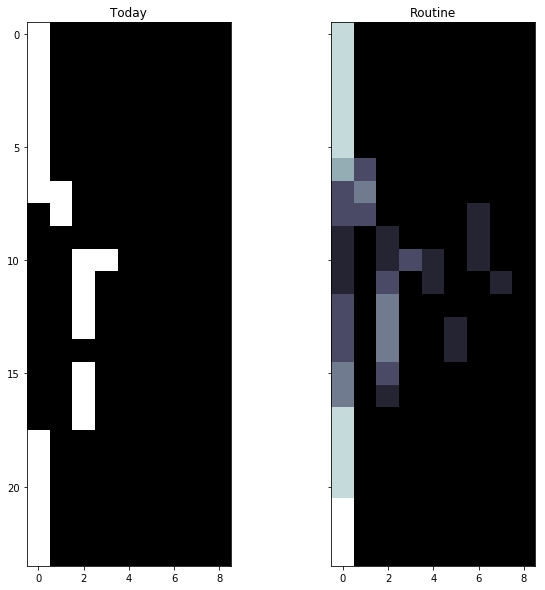

Routine index: 0.93
-----------------------------------


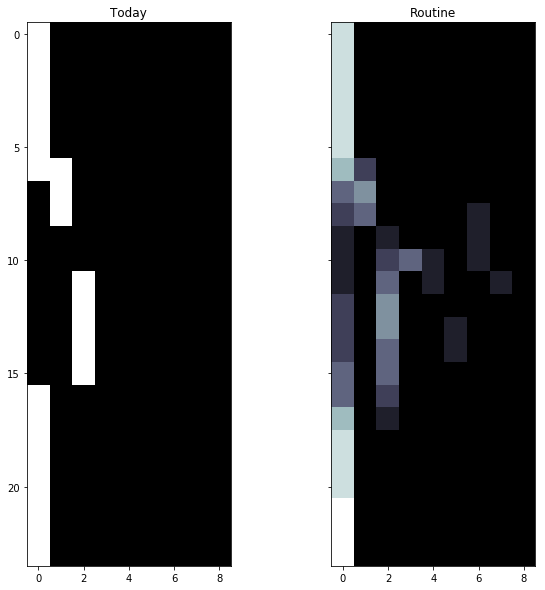

Routine index: 0.95
-----------------------------------


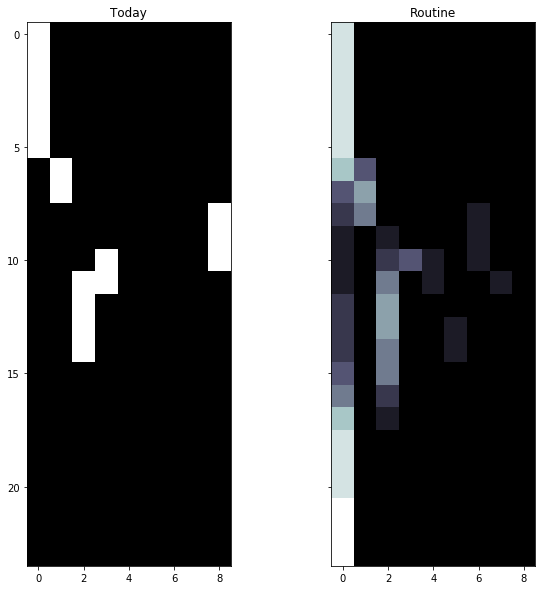

Routine index: 0.90
-----------------------------------


In [278]:
number_of_places = len(places)

for d in dates:
    # Calculate todays matrix
    stops_today = stops[stops.date == d]
    hour_matrix_today = make_binary_matrix(stops_today, number_of_places)
    
    
    dates_hist = dates[dates < d]
    if len(dates_hist) > 0:
        hour_matrices_hist = [make_binary_matrix(stops[stops.date == dh], number_of_places) for dh in dates_hist]
        routine_matrix = np.mean(hour_matrices_hist, axis=0)
        plot_today_and_routine(hour_matrix_today, routine_matrix)
        
        # Calc RI
        ri = RI(routine_matrix, hour_matrix_today)
    else:
        ri = -1
    print('Routine index: %0.2f' % ri)
    
    
    print('-'*35)

## Old approach: Updating the average

Quick example of how to incrementally update an average with a new datapoint

In [139]:
arr = np.arange(1, 10)
size = len(arr)
old_avg = arr.mean()
print('old avg:', old_avg)

new_avg = (old_avg * size + 10) / (size + 1)
print('new avg:', new_avg)

true_avg = np.arange(1, 11).mean()
print('true new avg', true_avg)

old avg: 5.0
new avg: 5.5
true new avg 5.5


In [140]:
def update_routine_matrix(m_old, num_samples, h):
    '''
    input:
        m_old (2d matrix): The old routine matrix 
        num_samples (integer): The number of days the old routine matrix is based on
        h (2d matrix): A new hour matrix observation for one day 
    
    output:
        m_new (2d matrix): Update routine matrix
        num_samples_new (integer): The updated number of samples
    '''
    
    # If old matrix is empty, then return the new matrix
    if m_old.sum() == 0:
        return h, 1
    
    # Expand dimensions to match, i.e add zero columns for new places
    difference = h.shape[1] - m_old.shape[1]
    m_new = np.concatenate((h, np.ones((HOURS_IN_A_DAY, difference))), axis=1)
    
    # Update average
    m_new = (m_old * num_samples + h) / (num_samples + 1)
    return m_new, num_samples + 1

In [141]:
# Init with a single place, since we assume no places have been found at the beginning
def init_routine_matrix():
    routine_matrix = np.zeros((HOURS_IN_A_DAY, 1)) 
    num_samples = 0
    
    return routine_matrix, num_samples